Notebook purpose

- Produce summary statistics and figures


In [7]:
from imports import *

%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

SAMPLE = 'XX7'

# global figure settings
DPI = 1200
ALPHA = 0.7
HISTTYPE = 'stepfilled'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
path = os.path.join(config.TEMPDIR, f'data_{SAMPLE}.parquet')
df = pd.read_parquet(path)
helpers.info(df)

## Age distribution

In [4]:
def get_pop_data():
    ukpop = pd.read_excel(
        os.path.join(config.DATADIR, 'ons', 'ons_pop.xls'), 
        sheet_name='MYE1',
        usecols=[0, 1],
        header=15,
        names=['age', 'n'],
        skipfooter=9
    )
    return ukpop

def make_pop_sample(df):
    df['age'] = df.age.str[:2].astype(int)
    df['n'] = df.n // 10000    
    sample = []
    for idx, s in pop.iterrows():
        sample += [s[0]] * s[1]
    return pd.DataFrame(sample, columns=['age'])

pop = get_pop_data()
samp = make_pop_sample(pop)

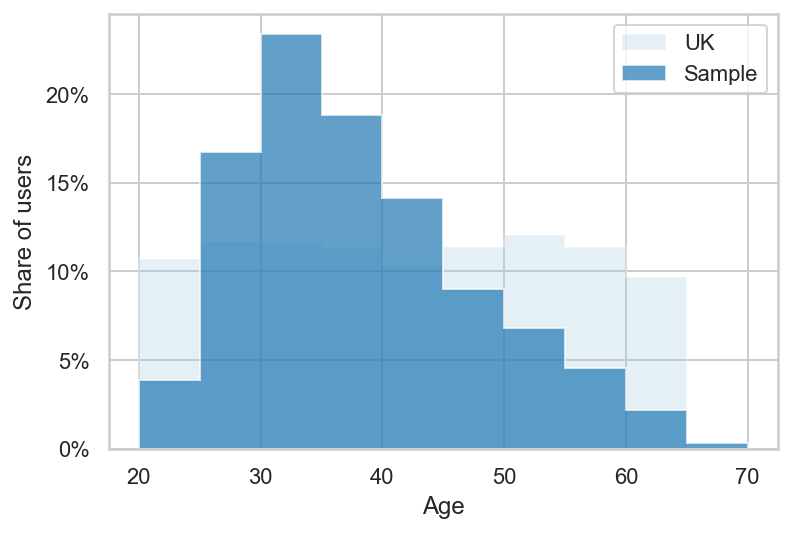

In [6]:
fig_name = 'sumstats_age_distr_anon.png'

age = 2020 - df.groupby('user_id').first().year_of_birth

bins = np.linspace(20, 70, 11)
weights = np.ones(len(age)) / len(age)

ukweights = np.ones(len(samp.age)) / len(samp.age)

k = plt.hist(samp.age, bins=bins, weights=ukweights, histtype=HISTTYPE, alpha=0.3, label='UK')
k = plt.hist(age, bins=bins, weights=weights, histtype=HISTTYPE, alpha=ALPHA, label='Sample')

yfmt = mpl.ticker.PercentFormatter(1, decimals=0)
plt.gca().yaxis.set_major_formatter(yfmt)
plt.xlabel('Age')
plt.ylabel('Share of users')
plt.legend()
plt.savefig(os.path.join(config.FIGDIR, fig_name), dpi=DPI)

## Income

In [5]:
def calc_income(df, earnings=False):
    """Return total 2019 incomes.
    
    Definition of income follows Hacioglu et al. (2020), where
    total income = earnings + pensions + benefits + other income.
    
    Optionally, consider earnings only.
    """
    if earnings:
        tag = 'earnings_income'
    else:
        tag = '_income'    
    mask = (df.tag.str.contains(tag) 
            & df.transaction_date.dt.year.eq(2019))
    return df[mask].groupby('user_id').amount.sum().abs()

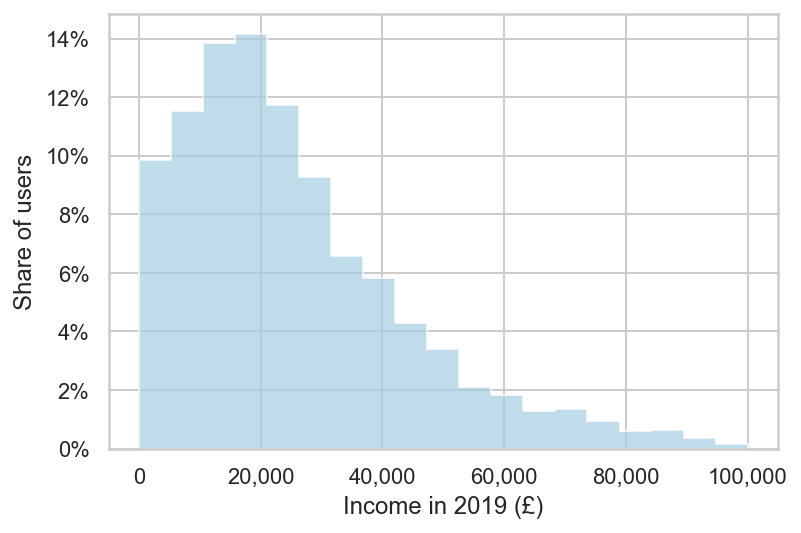

In [6]:
fig_name = 'sumstats_income_distr.png'

income = calc_income(df, earnings=False)
bins = np.linspace(0, 100000, 20)
wgt = np.ones(len(income)) / len(income)
yfmt = mpl.ticker.PercentFormatter(1, decimals=0)
xfmt = mpl.ticker.StrMethodFormatter('{x:,g}')

plt.hist(income, bins=bins, weights=wgt, histtype=HISTTYPE, alpha=ALPHA)
plt.gca().yaxis.set_major_formatter(yfmt)
plt.gca().xaxis.set_major_formatter(xfmt)
plt.xlabel('Income in 2019 (£)')
plt.ylabel('Share of users')
plt.savefig(os.path.join(config.FIGDIR, fig_name), dpi=DPI)

## Geographic representation

In [7]:
def get_sectors():
    path = os.path.join(config.DATADIR, 'ons', 'ons_postcodes.csv')
    res = (pd.read_csv(path, usecols=['pcds', 'rgn'])
           .assign(postcode = lambda df: df.pcds.str[:-2])
           .drop('pcds', axis=1)
           .dropna()
           .drop_duplicates())
    return res

sec = get_sectors()

In [8]:
def get_regions():
    path = os.path.join(config.DATADIR, 'ons', 'ons_regions.csv')
    res = (pd.read_csv(path, skiprows=[0], usecols=[0, 2], names=['rgn', 'region'])
           .assign(region = lambda df: df.region.str.replace('\(pseudo\)', '')
                   .astype('category')))
    return res

reg = get_regions()

In [9]:
sec_reg = (sec.merge(reg, validate='m:1')
           .assign(postcode = lambda df: df.postcode.str.lower())
           .drop('rgn', axis=1))
sec_reg.head()

,postcode,region
0,ab1 0,Scotland
1,ab1 1,Scotland
2,ab1 2,Scotland
3,ab1 3,Scotland
4,ab1 4,Scotland


In [10]:
areas = (df.groupby('user_id')
         .first().postcode
         .reset_index()
         .merge(sec_reg, how='left')
         .drop_duplicates(['user_id'])
         .dropna())

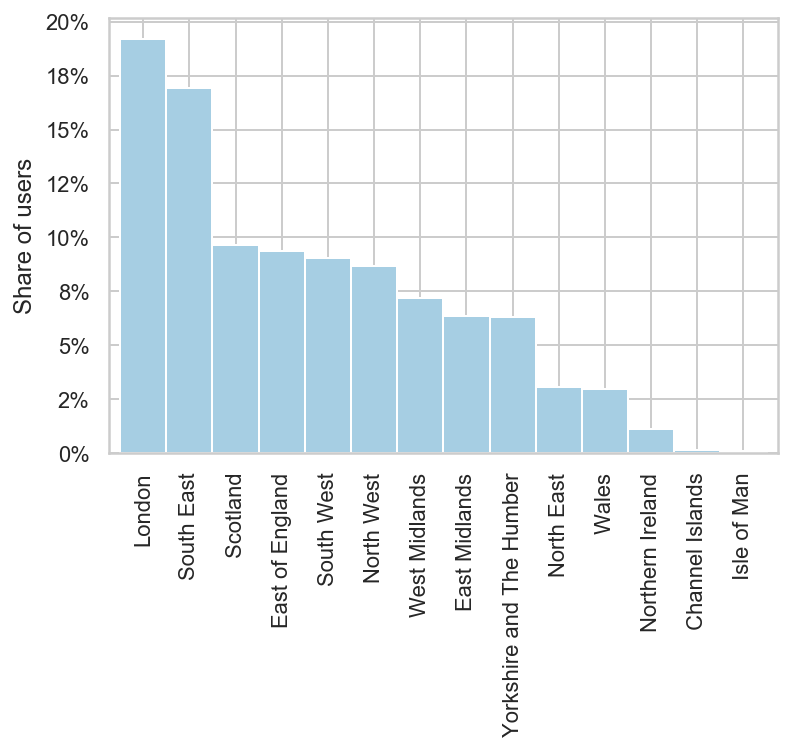

In [11]:
fig_name = 'sumstats_region_distr.png'

props = areas.region.value_counts() / len(areas)
props.plot(kind='bar', width=1)
yfmt = mpl.ticker.PercentFormatter(1, decimals=0)
plt.gca().yaxis.set_major_formatter(yfmt)

plt.ylabel('Share of users')
plt.savefig(os.path.join(config.FIGDIR, fig_name), dpi=DPI)

## Financial accounts

Number of financial accounts per user

In [12]:
accounts = (df.groupby(['user_id', df.account_type.astype(str)])
            .account_id.nunique()
            .unstack(fill_value=0)
            .drop('other', axis=1)
            .assign(total = lambda df: df.sum(1))
            [['total', 'current', 'credit card', 'savings']])
accounts.head(2)

account_type,total,current,credit card,savings
user_id,,,,
107,8,3,4,1
207,9,1,7,1


In [13]:
accounts.describe()

account_type,total,current,credit card,savings
count,3724.0000,3724.0000,3724.0000,3724.0000
mean,4.3633,2.1171,0.9509,1.2954
std,3.1078,1.4158,1.5444,1.5499
min,1.0000,1.0000,0.0000,0.0000
25%,2.0000,1.0000,0.0000,0.0000
50%,3.0000,2.0000,0.0000,1.0000
75%,6.0000,3.0000,1.0000,2.0000
max,26.0000,12.0000,17.0000,14.0000


In [14]:
month = pd.Grouper(freq='M', key='transaction_date')
m = df[df.amount > 0].groupby(['user_id', month]).amount.sum()

In [15]:
def sumstats_table(df, varlist, pctls=None, cols=None):
    """Produce summary statistics at user level."""
    if pctls is None:
        pctls = [.1, .25, .5, .75, .9]
    if cols is None:
        cols = ['mean', '10%', '25%', '50%', '75%', '90%']

    g = df.groupby('user_id')
    tbl = pd.DataFrame()

    for var in varlist:
        stats = g[var].nunique().describe(percentiles=pctls)
        frame = stats.to_frame().T
        tbl = tbl.append(frame)
    tbl.index = ['Banks', 'Accounts']
    tbl = tbl[cols].reset_index()
    tbl.columns = ['', 'Mean', 'p10', 'p25', 'p50', 'p75', 'p90']
    return tbl